# Analytic vs FEM solution

#### Import libaries

In [1]:
import sympy as sp 
import numpy as np 
import matplotlib.pyplot as plt 
from fjFEM1D_lib import post_proc

## Analytic solution

In [2]:
# variables and functions
x = sp.symbols('x')
u = sp.Function('u')(x)
p = sp.Function('p')(x)

# parameters
L = 100
EA = 7000
p0 = 2/10
F = 0

# line load
#p = sp.sin(sp.pi*x/L)*2/10
p = x**6/L/100000000


# Define the ODE
ode = sp.Eq(u.diff(x, 2) + p/EA, 0)

# Solve the ODE
sol = sp.dsolve(ode, u)

# Apply the boundary conditions
constants = sp.solve([sol.rhs.subs(x, 0), sol.rhs.subs(x, L)], sp.symbols('C1 C2'))
sol = sol.subs(constants)

# analytical dispalcement
u_ana = sol.rhs

# analytical axial force
N_ana = EA*sol.rhs.diff(x)

## Finite element solution
### Discretization

In [3]:
# number of elements
n = 4

# element order
eType = 'Lin1D'

# nodes
if eType == 'Lin1D':
    N = np.linspace(0, L, n+1)
    E = np.zeros((n, 2), dtype=int)
    E[:,0] = np.arange(2, n+2)
    E[:,1] = np.arange(1, n+1)

if eType == 'Quad1D':
    N = np.linspace(0, L, 2*n+1)
    E = np.zeros((n, 3), dtype=int)
    E[:,0] = np.arange(3, 2*n+2, 2)
    E[:,1] = np.arange(1, 2*n+1, 2)
    E[:,2] = np.arange(2, 2*n+1, 2)

# boundary conditons
BC = np.array([1, len(N)])

### Finite element mehtod

In [4]:
# *** START FINITE ELEMENT ANALYSIS ***

# number of nodes
numN = N.size
# number of elements
numE = E.shape

# global stiffness matrix
K = np.zeros((numN,numN), dtype="float")
# force vector due to line load
fp = np.zeros(numN, dtype="float")
# force vector due to point load
fF = np.zeros(numN, dtype="float")

# direct stiffness method
for i in range(0,numE[0]):

    # node indices
    ind = E[i,:] - 1
    # length of elment
    xr = N[ind[0]]
    xl = N[ind[1]]
    le = xr - xl

    # linear element
    if eType == "Lin1D":
        # element force vector
        # numerical integration
        xi = le*np.linspace(0, 1, 4)
        w = np.array([1/8, 3/8, 3/8, 1/8])
        fe = np.zeros(2, dtype="float")
        for j in range(0,4):
            pj = float(p.evalf(subs={x: xl + xi[j]}))
            fe += pj*w[j]*np.array([xi[j]/le, 1 - xi[j]/le], dtype="float")*le
    
        # element stiffness matrix
        Ke  = EA/le*np.array([[1, -1],[-1, 1]], dtype="float")

    # quadratic element
    if eType == "Quad1D":
        # element force vector
        # numerical integration
        xi = le*np.linspace(0, 1, 4)
        w = np.array([1/8, 3/8, 3/8, 1/8])
        fe = np.zeros(3, dtype="float")
        for j in range(0,4):
            pj = float(p.evalf(subs={x: xl + xi[j]}))
            fe += pj*w[j]*np.array([xi[j]*(2*xi[j] -le)/le**2, (le - xi[j])*(le - 2*xi[j])/le**2, 4*xi[j]*(le - xi[j])/le**2], dtype="float")*le
        # element stiffness matrix
        Ke = EA/(3*le)*np.array([[7, 1, -8],[1, 7, -8],[-8, -8, 16]], dtype="float") 

    # assemble global stiffness matrix and force vector
    K[np.ix_(ind,ind)] += Ke
    fp[ind] += fe

# determine force vector
f = fp + fF

# apply boundary condtions
for i in BC:
    K[i-1,:] = 0
    K[:,i-1] = 0
    K[i-1,i-1] = 1
    f[i-1] = 0

# solve linear system
uFEM = np.linalg.solve(K,f)

## Plot results

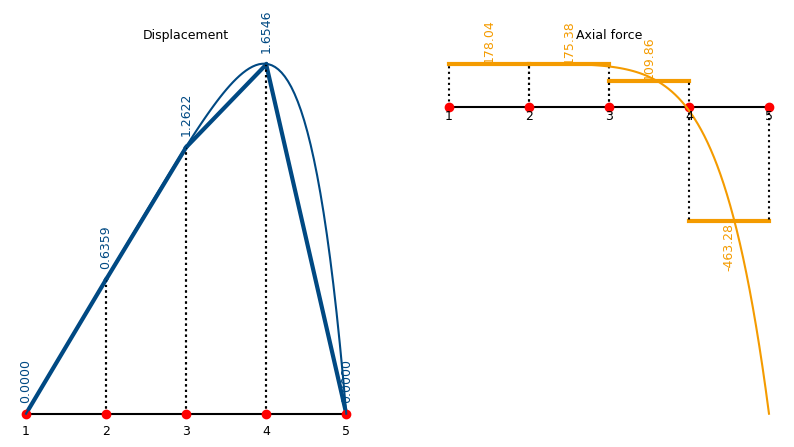

In [5]:
# plot FEM results
fjBlue = (0, 73/255, 131/255)
fjOrange = (244/255, 155/255, 0)

fig = post_proc(N, E, uFEM, eType, F, EA)
ax1, ax2 = fig.get_axes()

# evaluate analytical solution
# Generate x values
x_vals = np.linspace(0, L, 100)

# Evaluate the solution at x values
u_vals = [u_ana.subs(x, val) for val in x_vals]
N_vals = [N_ana.subs(x, val) for val in x_vals]

# plot analytical solution in the same figure
ax1.plot(x_vals, u_vals, color=fjBlue)
ax2.plot(x_vals, N_vals, color=fjOrange)

ax1.axis('off')
ax1.set_title('Displacement', fontsize=9)
ax2.axis('off')
ax2.set_title('Axial force', fontsize=9)
plt.show()